In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import yt
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
from matplotlib.colors import LogNorm
import os,sys

from galaxy_analysis.static_data import SOLAR_ABUNDANCE

# galaxy analysis methods (for comparison)
from galaxy_analysis.gizmo import yield_model
from galaxy_analysis.utilities import cy_convert_abundances as ca
from galaxy_analysis.plot.plot_styles import *
#--------------
import copy
# gizmo analysis methods 
import gizmo_analysis as gizmo
import utilities as gizmo_ut
from utilities.basic.binning import BinClass

#------------------------------
input_type = 'mass'

def plot_settings():
    fsize = 21
    rc('text',usetex=False)
    rc('font',size=fsize)
    return

plot_settings()

In [2]:
0.0001 * 10**(SOLAR_ABUNDANCE["Fe"] - SOLAR_ABUNDANCE["H"])

3.1622776601683795e-09

In [30]:
simulation = 'm12q'
wdir = "/home/aemerick/work/gizmo_runs/m10q_res130000/"
wdir = "/home/aemerick/work/gizmo_runs/m12q_res5700_test/"

initial_part = gizmo.io.Read.read_snapshots(['gas'],'index',0,simulation_directory=wdir)
initial = {}
for e in ['H','He','C','N','O','Ne','Mg','Si','S','Ca','Fe']:
    initial[str.lower(e)] = np.average(initial_part['gas'].prop('massfraction.' + str.lower(e)))
initial['metals'] = np.average(initial_part['gas'].prop('massfraction.metals'))
#
#
#
#
#
    
    
sim_index = 385

# load the data set
part = gizmo.io.Read.read_snapshots(['star'], 'index', sim_index,
                                    #assign_host_principal_axes=True, 
                                    simulation_directory = wdir)

z_solar_fire   = 0.02
z_solar_nugrid = 0.0245

z_fraction     = 0.02

FIRE2_models = {}
FIRE2_yield_tables = {}
fire_part = {}
for z in [0.0001, 0.001, 0.01, 0.02]:
    fire_part[z] = copy.deepcopy(part)
    
    FIRE2_models[z] =  gizmo.agetracers.FIRE2_yields(model_Z = z / z_solar_fire, Z_scaling = True)
    FIRE2_yield_tables[z] =  gizmo.agetracers.construct_yield_table(FIRE2_models[z], 
                                                                    fire_part[z].ageprop.age_bins/1000.0)

    fire_part[z].set_yield_table(FIRE2_yield_tables[z], FIRE2_models[z].elements)
    fire_part[z].set_initial_abundances(initial)


NuGrid_models = {}
NuGrid_yield_tables = {}
nugrid_part = {}
for z in [0.0001,0.001,0.01,0.02]:
    
    nugrid_part[z] = copy.deepcopy(part)
    
    NuGrid_models[z] = gizmo.agetracers.NuGrid_yields(
                                    iniZ = z, 
                                    imf_type = 'kroupa', 
                                    sn1a_rate = 'maoz', 
                                    table='yield_tables/agb_and_massive_stars_nugrid_MESAonly_fryer12delay.txt',
                                    special_timesteps=1000)
                                    
    
    
    NuGrid_yield_tables[z] = gizmo.agetracers.construct_yield_table(NuGrid_models[z], 
                                                                    nugrid_part[z].ageprop.age_bins/1000.0)
                                                                    

                                                           
    nugrid_part[z].set_yield_table(NuGrid_yield_tables[z], [str.lower(x) for x in NuGrid_models[z].elements])
    nugrid_part[z].set_initial_abundances(initial)




# in utilities.simulation.Snapshot():
* reading:  home/aemerick/work/gizmo_runs/m12q_res5700_test/snapshot_times.txt

  using snapshot index = 0, redshift = 99.000


# in gizmo_analysis.gizmo_io.Read():
* reading header from:  home/aemerick/work/gizmo_runs/m12q_res5700_test/output/snapshot_000.hdf5
  snapshot contains the following number of particles:
    dark      (id = 1): 16220880 particles
    dark2     (id = 2): 4132251 particles
    gas       (id = 0): 16220880 particles
    star      (id = 4): 0 particles
    blackhole (id = 5): 0 particles

* reading species: ['gas']
* reading gas properties: ['acceleration', 'density', 'electron.fraction', 'hydrogen.neutral.fraction', 'id', 'id.child', 'id.generation', 'mass', 'massfraction', 'position', 'potential', 'sfr', 'smooth.length', 'temperature', 'velocity']
* reading particles from:
    home/aemerick/work/gizmo_runs/m12q_res5700_test/output/snapshot_000.hdf5

! cannot find MUSIC config file:  home/aemerick/work/gizmo_runs/m12q_res5

In [7]:
gas_O = part['gas'].prop('mass.n') - np.min(part['gas'].prop('mass.n'))
select_enriched = gas_O > 0
age_O = part['gas'].prop('mass.agetracer.n')

np.size(gas_O[select_enriched])

13934176

In [55]:
#
#
# lets make a cool plot
#
#

def get_abundance(p, e1,e2, agetracer=False):
    prefix = 'metallicity'
    if agetracer:
        prefix = prefix + '.agetracer'
    if e2 != 'h':
        propname = prefix + '.' + e1 + ' - ' + prefix + '.' + e2
    else:
        propname = prefix + '.' + e1
    return p.prop(propname)
    
def mdf_plot(_ax, xvals, **kwargs):
    
    valmin = np.max([-8,np.min( xvals)]) - 0.001
    valmax = np.max(xvals) + 0.001
    
    bc    = BinClass([valmin,valmax],number= int((valmax-valmin)/0.1))
    hist = bc.get_histogram(xvals)
    
    _ax.plot(bc.mids, hist/(1.0*np.sum(hist)) / bc.widths, lw=3, **kwargs)
    
    return

def lineplot(_ax, xvals, yvals, **kwargs):
    
    valmin = np.max([-8,np.min( xvals)]) - 0.001
    valmax = np.max(xvals) + 0.001
    
    bc    = BinClass([valmin,valmax],number= int((valmax-valmin)/0.1))
    stats = bc.get_statistics_of_array(xvals,yvals)
    
    
    
    _ax.plot(stats['bin.mid'][:-1], stats['median'][:-1], lw = 3, **kwargs)
    
    fill_kwargs = kwargs
    if 'label' in fill_kwargs:
        del fill_kwargs['label']
    
    _ax.fill_between(stats['bin.mid'], stats['percent.16'], stats['percent.84'], alpha=0.2,
                     lw = 3, **fill_kwargs)
    
    #print(stats['bin.mid'])
    return
    


In [35]:
bc = BinClass([-4.5,1],number=int((1+4.5)/0.1))


In [48]:
np.size(bc.get_histogram(np.ones(100)))



55

[6.26413289e-06 5.84268153e-07 2.67843837e-07 2.51567597e-08
 1.23285080e-08 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
[7.22096385e-06 1.75178799e-05 4.25874269e-03 3.69839648e-04
 7.24121072e-03 5.00005184e-05 3.68376591e-05 3.67864472e-05
 3.02012461e-05 1.98272068e-05 4.11361433e-05 4.78965203e-05
 4.83920287e-05 3.85844917e-05 2.30592993e-05 2.17108327e-05]


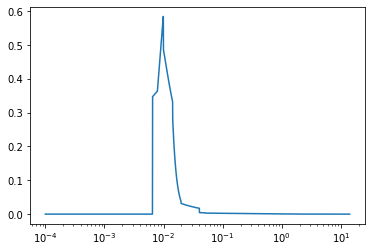

In [44]:
plt.plot(NuGrid_model._model_time[1:], NuGrid_model._model_yield_rate[:,6])
plt.semilogx()

print(NuGrid_yield_table[:,NuGrid_model.elements.index('O')])
print(yield_table[:,4])

Plotting [c/fe] for all models
Plotting [n/fe] for all models
Plotting [o/fe] for all models
Plotting [ne/fe] for all models
Plotting [mg/fe] for all models
Plotting [si/fe] for all models
Plotting [s/fe] for all models
Plotting [ca/fe] for all models
Plotting [fe/fe] for all models


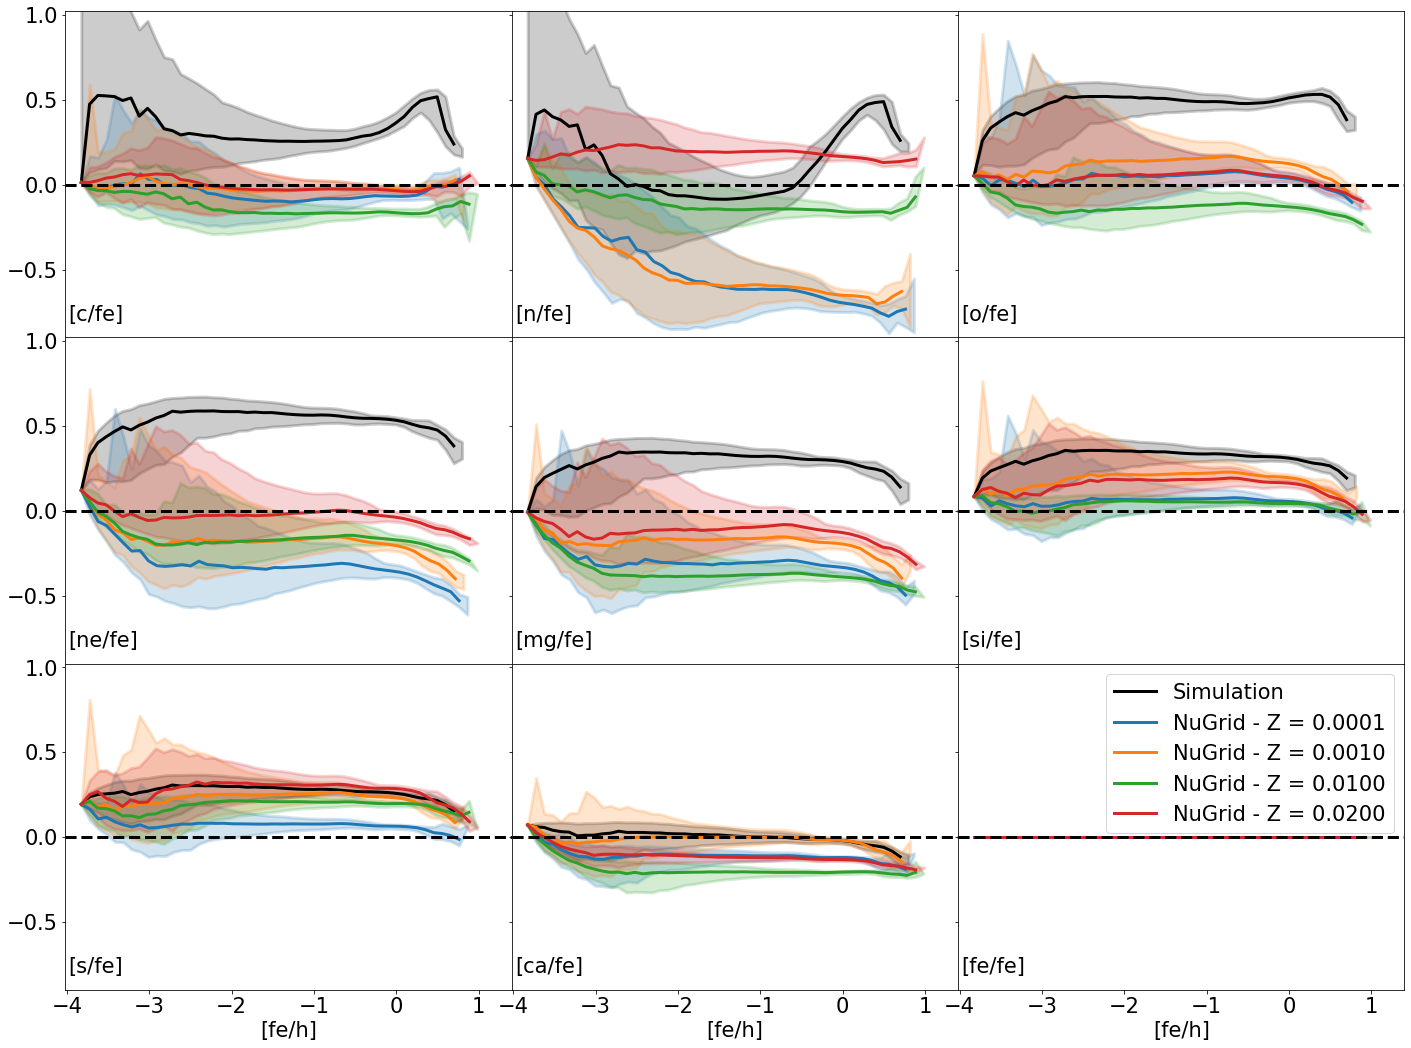

In [31]:
#
#
# lets make a cool plot
#
#
plot_settings()

fig, all_ax = plt.subplots(3,3,sharex=True,sharey=True)
fig.set_size_inches(8*3,6*3)

fig.subplots_adjust(wspace=0,hspace=0)

ye1,ye2 = 'XXX','fe'
xe1,xe2 = 'fe','h'

y_elements = ['c','n','o','ne','mg','si','s','ca','fe']

count = 0
for ax2 in all_ax:
    for ax in ax2:
        
        ye1 = y_elements[count]
        
        print("Plotting [" + ye1 + "/" + ye2 + "] for all models")
        
    
        lineplot(ax, get_abundance(part['star'],xe1,xe2), get_abundance(part['star'],ye1,ye2),
                 color = 'black', label="Simulation")
        
        for i,z in enumerate([0.0001,0.001,0.01,0.02]):
            lineplot(ax, get_abundance(nugrid_part[z]['star'],xe1,xe2,True), 
                         get_abundance(nugrid_part[z]['star'],ye1,ye2,True),
                         color = 'C%i'%(i), label="NuGrid - Z = %4.4f"%(z))
            

        ax.set_xlim(-4.02,1.4)
        ax.set_ylim(-0.9,1.02)

        #ax.set_ylabel(r"[" + ye1 + "/" + ye2 +"]")
        x = -3.98
        y = -0.8
        ax.text(x,y,r"[" + ye1 + "/" + ye2 +"]")
        ax.plot(ax.get_xlim(),[0.0,0.0],lw=3,color='black',ls='--')

        if count > 5:
            ax.set_xlabel(r"[" + xe1 + "/" + xe2 +"]")
        count = count + 1

all_ax[(2,2)].legend(loc='best')
fig.savefig("NuGrid_postprocessing_test_fe_h.png")

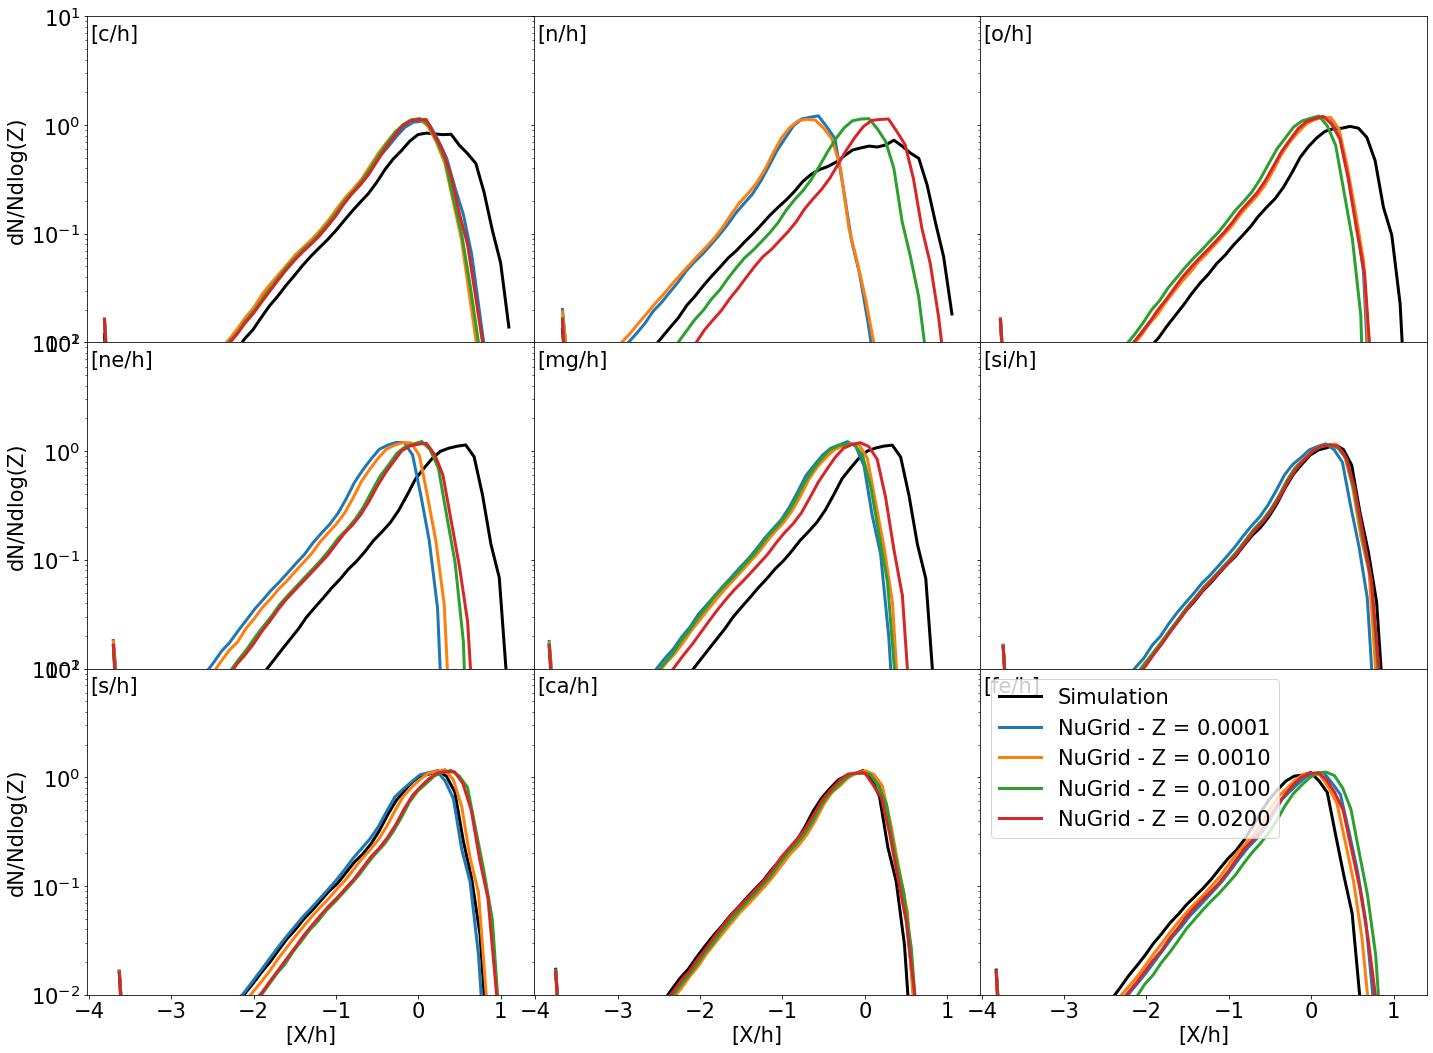

In [58]:
#
#
# lets make a cool plot
#
#
plot_settings()

fig, all_ax = plt.subplots(3,3,sharex=True,sharey=True)
fig.set_size_inches(8*3,6*3)

fig.subplots_adjust(wspace=0,hspace=0)

xe1,xe2 = 'xxx','h'

x_elements = ['c','n','o','ne','mg','si','s','ca','fe']

count = 0
for ax2 in all_ax:
    for ax in ax2:
        
        xe1 = x_elements[count]        
    
        mdf_plot(ax, get_abundance(part['star'],xe1,xe2),
                 color = 'black', label="Simulation")
        
        for i,z in enumerate([0.0001,0.001,0.01,0.02]):
            mdf_plot(ax, get_abundance(nugrid_part[z]['star'],xe1,xe2,True), 
                         color = 'C%i'%(i), label="NuGrid - Z = %4.4f"%(z))
            

        ax.set_xlim(-4.02,1.4)
        ax.set_ylim(0.01,10.0)

        #ax.set_ylabel(r"[" + ye1 + "/" + ye2 +"]")
        x = -3.98
        y = 6.
        ax.text(x,y,r"[" + xe1 + "/" + xe2 +"]")
        ax.plot(ax.get_xlim(),[0.0,0.0],lw=3,color='black',ls='--')
        ax.semilogy()
        
        
        if count > 5:
            ax.set_xlabel(r"[X/" + xe2 +"]")
        count = count + 1
        
for i in np.arange(3):
    all_ax[(i,0)].set_ylabel('dN/Ndlog(Z)')

all_ax[(2,2)].legend(loc='best')
fig.savefig("NuGrid_postprocessing_MDF.png")

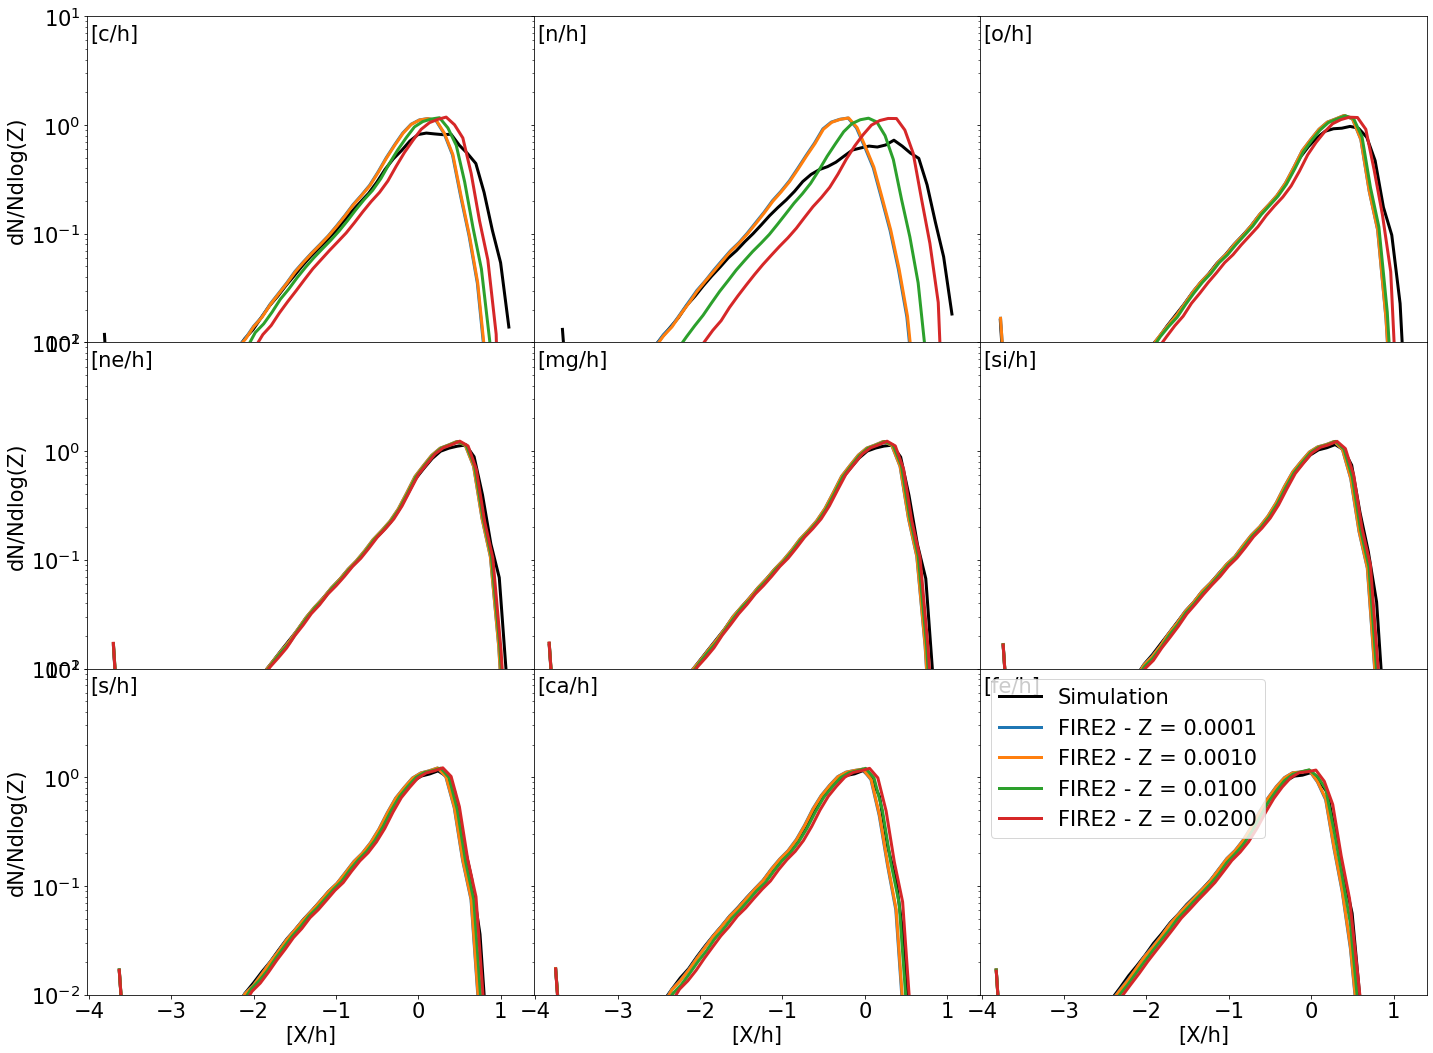

In [59]:
#
#
# lets make a cool plot
#
#
plot_settings()

fig, all_ax = plt.subplots(3,3,sharex=True,sharey=True)
fig.set_size_inches(8*3,6*3)

fig.subplots_adjust(wspace=0,hspace=0)

xe1,xe2 = 'xxx','h'

x_elements = ['c','n','o','ne','mg','si','s','ca','fe']

count = 0
for ax2 in all_ax:
    for ax in ax2:
        
        xe1 = x_elements[count]        
    
        mdf_plot(ax, get_abundance(part['star'],xe1,xe2),
                 color = 'black', label="Simulation")
        
        for i,z in enumerate([0.0001,0.001,0.01,0.02]):
            mdf_plot(ax, get_abundance(fire_part[z]['star'],xe1,xe2,True), 
                         color = 'C%i'%(i), label="FIRE2 - Z = %4.4f"%(z))
            

        ax.set_xlim(-4.02,1.4)
        ax.set_ylim(0.01,10.0)

        #ax.set_ylabel(r"[" + ye1 + "/" + ye2 +"]")
        x = -3.98
        y = 6.
        ax.text(x,y,r"[" + xe1 + "/" + xe2 +"]")
        ax.plot(ax.get_xlim(),[0.0,0.0],lw=3,color='black',ls='--')
        ax.semilogy()
        
        
        if count > 5:
            ax.set_xlabel(r"[X/" + xe2 +"]")
        count = count + 1
        
for i in np.arange(3):
    all_ax[(i,0)].set_ylabel('dN/Ndlog(Z)')

all_ax[(2,2)].legend(loc='best')
fig.savefig("FIRE2_postprocessing_MDF.png")

Plotting [c/fe] for all models
Plotting [n/fe] for all models
Plotting [o/fe] for all models
Plotting [ne/fe] for all models
Plotting [mg/fe] for all models
Plotting [si/fe] for all models
Plotting [s/fe] for all models
Plotting [ca/fe] for all models
Plotting [fe/fe] for all models


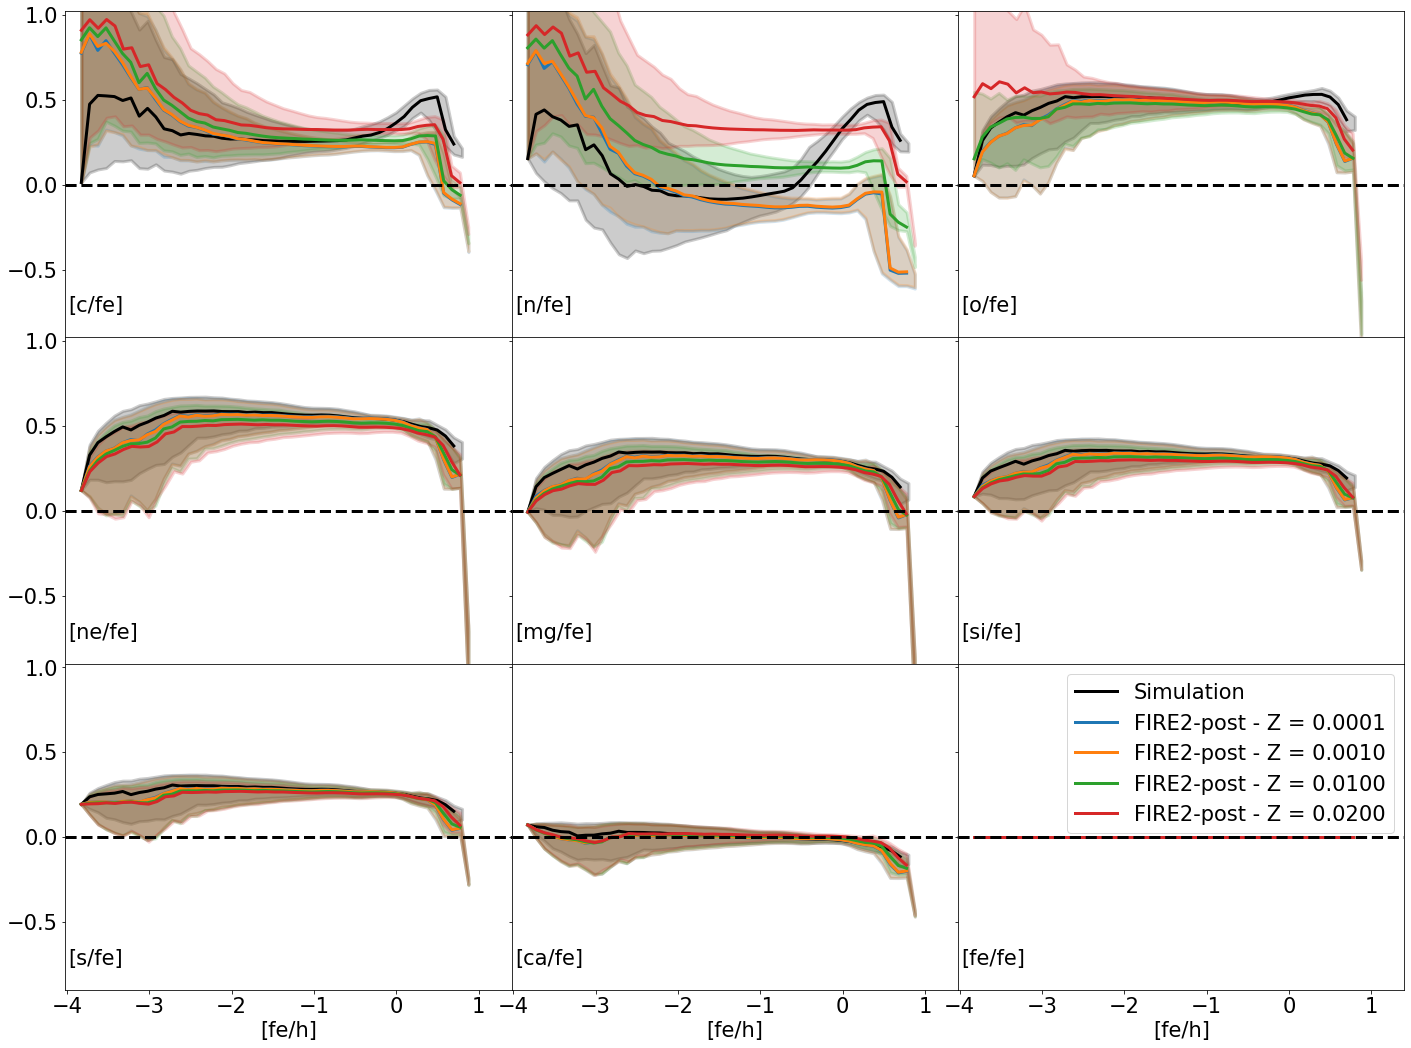

In [32]:

#
#
# lets make a cool plot
#
#
plot_settings()

fig, all_ax = plt.subplots(3,3,sharex=True,sharey=True)
fig.set_size_inches(8*3,6*3)

fig.subplots_adjust(wspace=0,hspace=0)

ye1,ye2 = 'XXX','fe'
xe1,xe2 = 'fe','h'

y_elements = ['c','n','o','ne','mg','si','s','ca','fe']

count = 0
for ax2 in all_ax:
    for ax in ax2:
        
        ye1 = y_elements[count]
        
        print("Plotting [" + ye1 + "/" + ye2 + "] for all models")
        
    
        lineplot(ax, get_abundance(part['star'],xe1,xe2), get_abundance(part['star'],ye1,ye2),
                 color = 'black', label="Simulation")
        
        for i,z in enumerate([0.0001,0.001,0.01,0.02]):
            lineplot(ax, get_abundance(fire_part[z]['star'],xe1,xe2,True), 
                         get_abundance(fire_part[z]['star'],ye1,ye2,True),
                         color = 'C%i'%(i), label="FIRE2-post - Z = %4.4f"%(z))

            

        ax.set_xlim(-4.02,1.4)
        ax.set_ylim(-0.9,1.02)

        #ax.set_ylabel(r"[" + ye1 + "/" + ye2 +"]")
        x = -3.98
        y = -0.75
        ax.text(x,y,r"[" + ye1 + "/" + ye2 +"]")
        
        ax.plot(ax.get_xlim(),[0.0,0.0],lw=3,color='black',ls='--')
        
        if count > 5:
            ax.set_xlabel(r"[" + xe1 + "/" + xe2 +"]")
        count = count + 1

all_ax[(2,2)].legend(loc='best')    
fig.savefig("FIRE2_postprocessing_test_fe_h.png")

Plotting [c/si] for all models
Plotting [n/si] for all models
Plotting [o/si] for all models
Plotting [ne/si] for all models
Plotting [mg/si] for all models
Plotting [si/si] for all models


/home/aemerick/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/aemerick/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
/home/aemerick/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Plotting [s/si] for all models
Plotting [ca/si] for all models
Plotting [fe/si] for all models


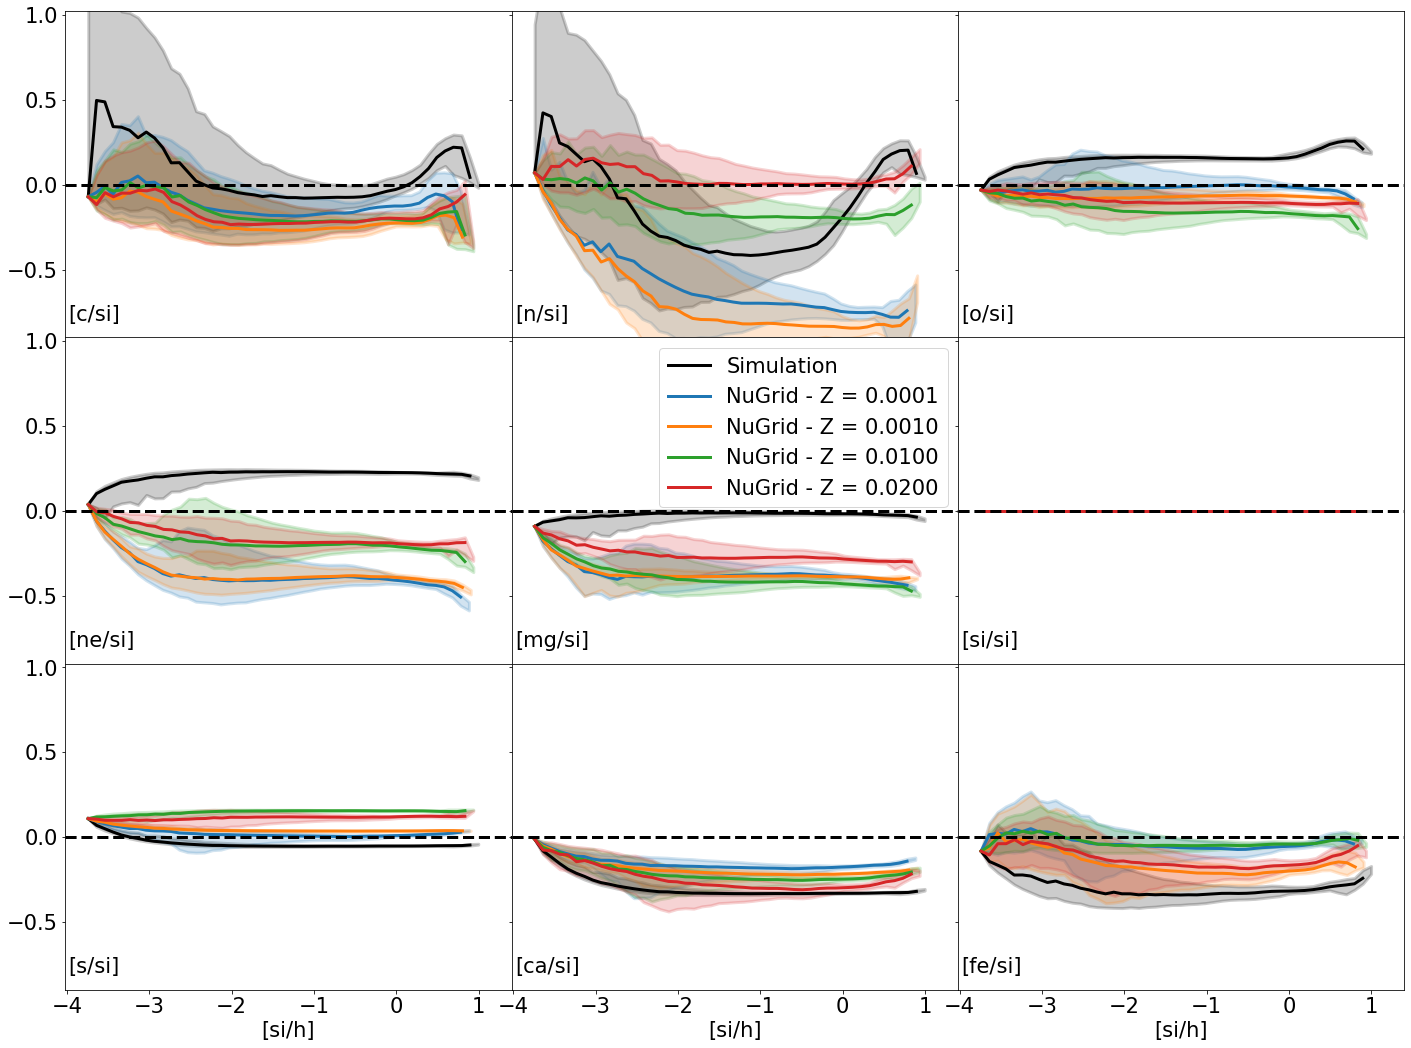

In [60]:
#
#
# lets make a cool plot
#
#
plot_settings()

fig, all_ax = plt.subplots(3,3,sharex=True,sharey=True)
fig.set_size_inches(8*3,6*3)

fig.subplots_adjust(wspace=0,hspace=0)

ye1,ye2 = 'XXX','si'
xe1,xe2 = 'si','h'

y_elements = ['c','n','o','ne','mg','si','s','ca','fe']

count = 0
for ax2 in all_ax:
    for ax in ax2:
        
        ye1 = y_elements[count]
        
        print("Plotting [" + ye1 + "/" + ye2 + "] for all models")
        
    
        lineplot(ax, get_abundance(part['star'],xe1,xe2), get_abundance(part['star'],ye1,ye2),
                 color = 'black', label="Simulation")
        
        for i,z in enumerate([0.0001,0.001,0.01,0.02]):
            lineplot(ax, get_abundance(nugrid_part[z]['star'],xe1,xe2,True), 
                         get_abundance(nugrid_part[z]['star'],ye1,ye2,True),
                         color = 'C%i'%(i), label="NuGrid - Z = %4.4f"%(z))
            

        ax.set_xlim(-4.02,1.4)
        ax.set_ylim(-0.9,1.02)

        #ax.set_ylabel(r"[" + ye1 + "/" + ye2 +"]")
        x = -3.98
        y = -0.8
        ax.text(x,y,r"[" + ye1 + "/" + ye2 +"]")
        ax.plot(ax.get_xlim(),[0.0,0.0],lw=3,color='black',ls='--')

        if count > 5:
            ax.set_xlabel(r"[" + xe1 + "/" + xe2 +"]")
        count = count + 1

all_ax[(1,1)].legend(loc='best')
fig.savefig("NuGrid_postprocessing_test_mg_h.png")

Plotting [c/mg] for all models
Plotting [n/mg] for all models
Plotting [o/mg] for all models
Plotting [ne/mg] for all models
Plotting [mg/mg] for all models


/home/aemerick/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


Plotting [si/mg] for all models
Plotting [s/mg] for all models
Plotting [ca/mg] for all models
Plotting [fe/mg] for all models


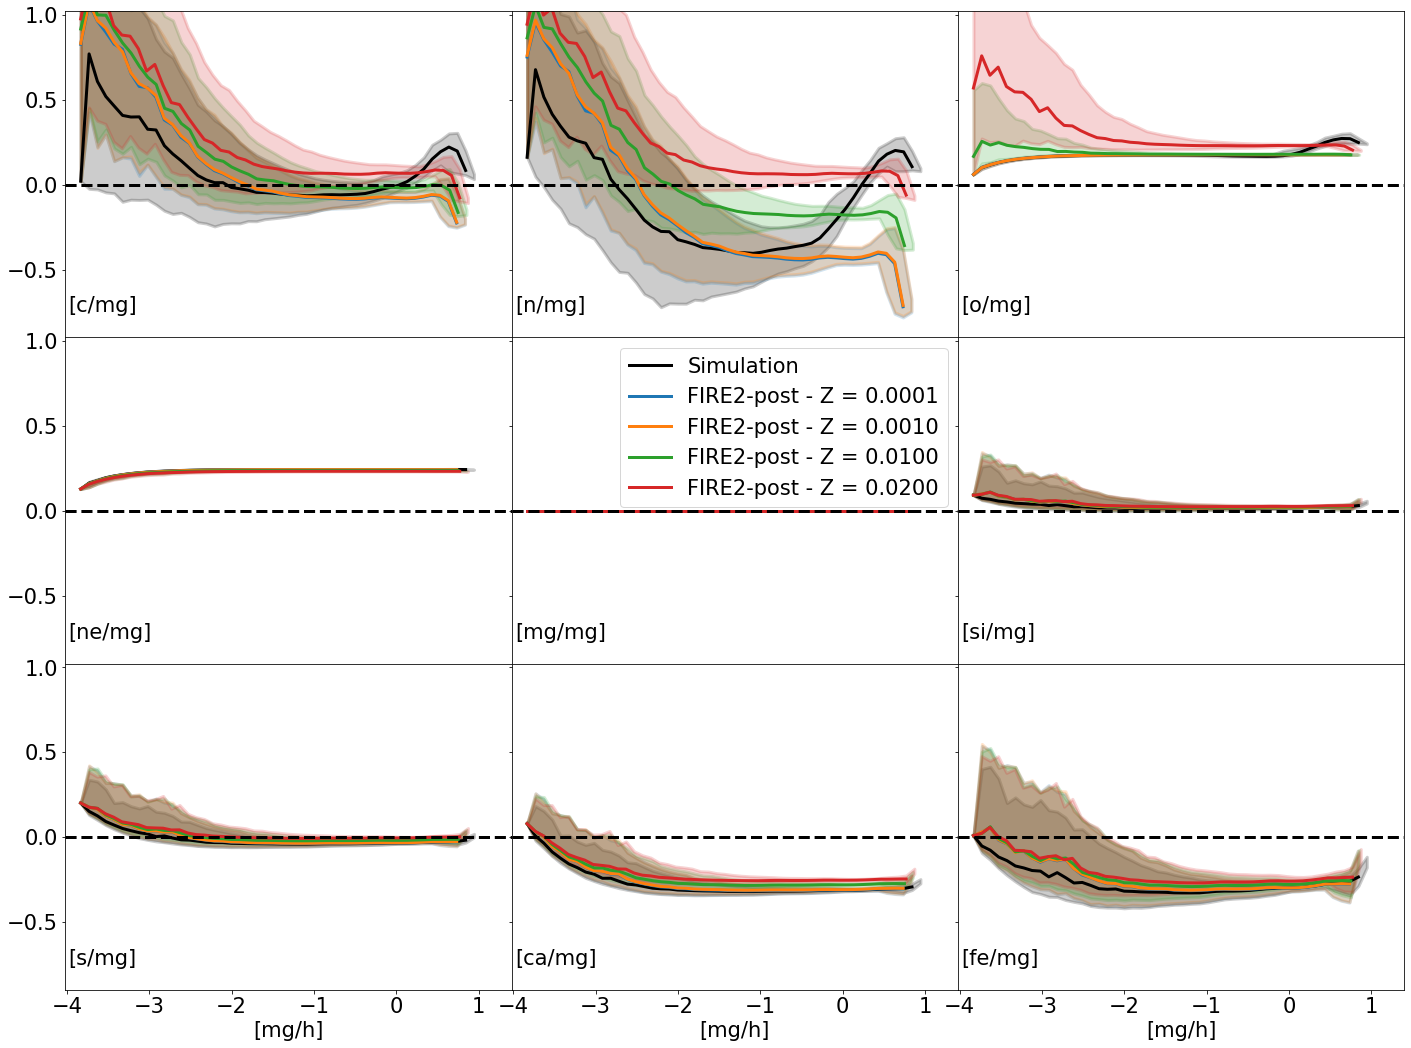

In [17]:

#
#
# lets make a cool plot
#
#
plot_settings()

fig, all_ax = plt.subplots(3,3,sharex=True,sharey=True)
fig.set_size_inches(8*3,6*3)

fig.subplots_adjust(wspace=0,hspace=0)

ye1,ye2 = 'XXX','mg'
xe1,xe2 = 'mg','h'

y_elements = ['c','n','o','ne','mg','si','s','ca','fe']

count = 0
for ax2 in all_ax:
    for ax in ax2:
        
        ye1 = y_elements[count]
        
        print("Plotting [" + ye1 + "/" + ye2 + "] for all models")
        
    
        lineplot(ax, get_abundance(part['star'],xe1,xe2), get_abundance(part['star'],ye1,ye2),
                 color = 'black', label="Simulation")
        
        for i,z in enumerate([0.0001,0.001,0.01,0.02]):
            lineplot(ax, get_abundance(fire_part[z]['star'],xe1,xe2,True), 
                         get_abundance(fire_part[z]['star'],ye1,ye2,True),
                         color = 'C%i'%(i), label="FIRE2-post - Z = %4.4f"%(z))

            

        ax.set_xlim(-4.02,1.4)
        ax.set_ylim(-0.9,1.02)

        #ax.set_ylabel(r"[" + ye1 + "/" + ye2 +"]")
        x = -3.98
        y = -0.75
        ax.text(x,y,r"[" + ye1 + "/" + ye2 +"]")
        
        ax.plot(ax.get_xlim(),[0.0,0.0],lw=3,color='black',ls='--')
        
        if count > 5:
            ax.set_xlabel(r"[" + xe1 + "/" + xe2 +"]")
        count = count + 1

all_ax[(1,1)].legend(loc='best')    
fig.savefig("FIRE2_postprocessing_test_mg_h.png")

Plotting [ba/fe] for all models
Plotting [sr/fe] for all models
Plotting [y/fe] for all models


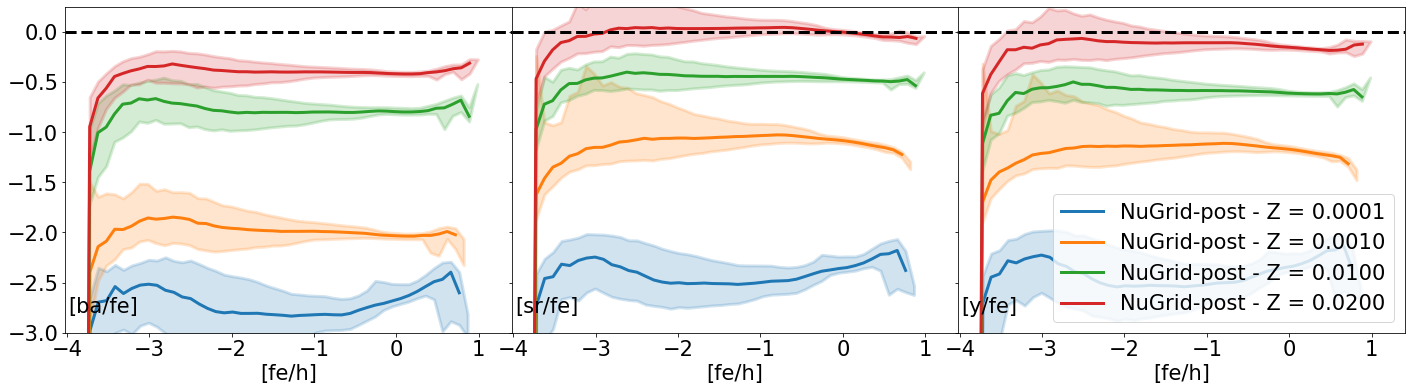

In [16]:

#
#
# lets make a cool plot
#
#
plot_settings()

fig, all_ax = plt.subplots(1,3,sharex=True,sharey=True)
fig.set_size_inches(8*3,6*1)

fig.subplots_adjust(wspace=0,hspace=0)

ye1,ye2 = 'XXX','fe'
xe1,xe2 = 'fe','h'

y_elements = ['ba','sr','y']

count = 0
for ax in all_ax:
    #for ax in ax2:
        
        ye1 = y_elements[count]
        
        print("Plotting [" + ye1 + "/" + ye2 + "] for all models")
        
    
       # lineplot(ax, get_abundance(part['star'],xe1,xe2), get_abundance(part['star'],ye1,ye2),
       #          color = 'black', label="Simulation")
        
        for i,z in enumerate([0.0001,0.001,0.01,0.02]):
            lineplot(ax, get_abundance(nugrid_part[z]['star'],xe1,xe2,True), 
                         get_abundance(nugrid_part[z]['star'],ye1,ye2,True),
                         color = 'C%i'%(i), label="NuGrid-post - Z = %4.4f"%(z))

            

        ax.set_xlim(-4.02,1.4)
        ax.set_ylim(-3,0.25)

        #ax.set_ylabel(r"[" + ye1 + "/" + ye2 +"]")
        x = -3.98
        y = -2.8
        ax.text(x,y,r"[" + ye1 + "/" + ye2 +"]")
        
        ax.plot(ax.get_xlim(),[0.0,0.0],lw=3,color='black',ls='--')
        
        ax.set_xlabel(r"[" + xe1 + "/" + xe2 +"]")
        count = count + 1

all_ax[2].legend(loc='best')    
fig.savefig("NuGrid_postprocessing_test_sproc.png")

In [30]:
'ba' in nugrid_part[0.02]['star']._postprocess_elements

True

In [6]:
#
# How to generate yields:
#

age_bins = yield_model.get_bins(config_file = wdir + "/gizmo.out", binfile = wdir+"/age_bins.txt")

Z = 0.0002
FIRE_Z_scaling = True
age_is_fraction = True

total_yields = yield_model.construct_yields(age_bins/1000.0, # pass bins as Gyr, Z = Z,
                                    Z = Z, yieldtype = 'total', FIRE_Z_scaling=FIRE_Z_scaling)
ds0     = yt.load(wdir + 'output/snapshot_000.hdf5')
data0   = ds0.all_data()
fields = ds0.field_list

# generate
yield_model.generate_metal_fields(ds0,_agebins=age_bins,_yields=total_yields, age_is_fraction=age_is_fraction)
#yield_model._generate_star_metal_fields(ds0, _agebins = age_bins, _yields = total_yields)

metals = np.unique([x[1] for x in ds0.field_list if ((x[0] == 'PartType0') and ('Metal' in x[1]))])

initial_abundance=np.zeros(15)
for i in np.arange(np.size(initial_abundance)):
    z = data0[('PartType0','Metallicity_%02i'%(i))]
    #print("%5.5E %5.5E %5.5E"%(np.min(z),np.max(z),np.average(z)))

    initial_abundance[i] = np.average(z).value
    
    #print(np.min(z).value,np.average(z).value,np.max(z).value)
    
logH = np.log10(ds0.hubble_constant)
ds     = yt.load(wdir + 'output/snapshot_%003i.hdf5'%(sim_index))
data   = ds.all_data()
fields = ds.field_list

# generate
yield_model.generate_metal_fields(ds,_agebins=age_bins,_yields=total_yields,age_is_fraction=age_is_fraction)
yield_model._generate_star_metal_fields(ds, _agebins = age_bins, _yields = total_yields,age_is_fraction=age_is_fraction)

ptypes = np.unique([x[0] for x in ds.field_list])
metals = np.unique([x[1] for x in ds.field_list if ((x[0] == 'PartType0') and ('Metal' in x[1]))])
# load ds and generate yields

N yield in SNII is less than zero due to FIRE scaling
N yield in SNIA is negative
Total O yield in winds is negative due to Z scaling


In [ ]:
yt_answer = data[('all','PartType4_O_mass')]
pm = part['star'].prop('mass')

In [ ]:
yt_answer.value #+ initial_abundance[4] * pm

In [ ]:
O - initial_abundance[4]*pm

In [ ]:
part['star'].prop('agetracer.mass.o')

In [ ]:
mass / yt_answer.value

In [ ]:
1/(part['star'].prop('mass') / (mass/yt_answer.value))

In [ ]:
#for i in np.arange(16):
    #print(np.abs((total_yields[:,i]-yield_table[:,i]) / (total_yields[:,i])))

In [ ]:
yield_table[:,4]

In [ ]:
yield_model.construct_yields?

In [ ]:
age_bins

In [ ]:
FIRE2_model.snII_yields

In [ ]:
data[('PartType4','Metallicity_30')]

In [ ]:
part['star']['massfraction'][:,30]

In [ ]:
part['star']['massfraction'][:,30]

In [ ]:
part['star']['mass'] / 1.0E10